# 库导入

In [494]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
from collections import OrderedDict #保持Key的顺序
import time
# from WindPy import *
# w.start()

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 数据下载与储存

## 登录聚宽下载数据

In [566]:
import jqdatasdk as jq
jq.auth('13918852005','960312Lsc')

In [567]:
futures_df = jq.get_all_securities(['futures'])

In [569]:
# mainfutures_df = futures_df[(futures_df['display_name'].str.contains('主力合约')) & (~futures_df['display_name'].str.contains('国债'))].copy()
mainfutures_df = futures_df[futures_df['display_name'].str.contains('期货指数')].copy()

In [571]:
mainfutures_CodeName = dict(zip(mainfutures_df.index.tolist(),mainfutures_df.display_name))

In [572]:
mainfutures_list = mainfutures_df.index.tolist()

In [573]:
mainfutures_TradeData_dict = {}
for fu in mainfutures_list:
    mainfutures_TradeData_tmp = jq.get_price(fu, start_date='2005-01-01', end_date='2019-09-06', frequency='daily', fields=['open', 'close', 'low', 'high', 'volume', 'money', 'factor', 'high_limit','low_limit', 'avg', 'open_interest'], skip_paused=False, fq='pre', count=None)
    mainfutures_TradeData_dict[fu] = mainfutures_TradeData_tmp

In [574]:
mainfutures_TradeData_df = pd.DataFrame()
for key in mainfutures_TradeData_dict.keys():
    mainfutures_TradeData_df_tmp = mainfutures_TradeData_dict[key].copy()
    mainfutures_TradeData_df_tmp['class_name'] = mainfutures_CodeName[key]
    mainfutures_TradeData_df_tmp['class'] = key
    mainfutures_TradeData_df = pd.concat([mainfutures_TradeData_df,mainfutures_TradeData_df_tmp],axis=0)

In [575]:
%%time
mainfutures_TradeData_df.to_csv('D:/TrendStrategyData/mainfutures_TradeData.csv')

Wall time: 3.5 s


## 读取本地数据

In [576]:
mainfutures_TradeData_df = pd.read_csv('D:/TrendStrategyData/mainfutures_TradeData.csv',index_col=0)

# 趋势跟踪策略
学术上定义的趋势跟踪，以 Moskowitz et al. (2012) 为代表，用过去 N 个月的收益率符号表示。当过去 N 个月收益为正时，则看多；相反，当过去 N 个月收益为负时，则看空。**收益率符号法常被称为时间序列动量（time series momentum, TSMOM）**，可能是最简单的趋势跟踪规则了，在后来的学术文章中广泛使用。  
Yang, Qian, and Belton (2019) 在讨论趋势跟踪时，介绍了其存在的三宗罪，其中一点是便是对收益率符号的诟病。Yang et al. (2019) 认为，**基于资产过去收益率符号的规则，要么是多头要么是空头，无论何时都会持有仓位，即使没有明显趋势的时候也会持仓，这样就会过度受到噪音的影响，无端带来多余的成本甚至亏损**。  
Baltas and Kosowski (2017) 也讨论过这个问题，他们认为，更精细的交易规则能提升趋势跟踪模型的效果，于是提出了另外一个规则，用收益率的 Newey-West t 统计量作为指标，这样就不会陷入要么 1 要么 -1 的争论。具体来说，对于某个资产，计算其过去 12 个月的日收益率的 Newey-West t 统计量，统计量大于1则为多，统计量小于-1则为空，否则卖空或买多对应的数值。

## 一点想法  - 理论
**上述内容是针对单品种趋势策略的改进，增加了单品种上趋势信号之间的区别，一下想法是在横截面上增强趋势信号之间的区别**
一个均线策略的输出信号是+1、-1形式的，多个均线策略的投票组合信号依然是离散的，且在不同资产中的均线信号缺乏可比性，无法通过均线信号进行类似因子分组的研究  
将**不可比较的离散均线策略信号**转化为**可比较的离散均线策略信号**后可以对不同资产释放出的均线信号进行横截面上筛选  
**转化方式**  
$$ r_{t,i}=\beta_{t,0}+\sum_{j}\beta_{t,j}MAsignal_{t-1,i,n_j}+\epsilon_t $$
$$ \tilde{\beta}_{t,j}=\frac{1}{N}\sum_{k=0}^{N-1}\hat{\beta}_{t-k,j}\omega_k $$
PS：特点在于对多均线策略的{+1，-1，...}信号组合附加了可比值$\hat{r}_{t,i}$

## 一点想法  - 实践
$\hat{r}_{t,i}$类似因子，可对资产进行分组，是一种应用于多品种期货的均线策略

### 均线因子计算 - 策略频率可选

In [577]:
how = 'W'

In [578]:
# 转化为月度数据
mainfutures_TradeData_df_ = mainfutures_TradeData_df.copy()
mainfutures_TradeData_df_.index = pd.to_datetime(mainfutures_TradeData_df_.index)
mainfutures_TradeData_df_['date'] = mainfutures_TradeData_df_.index
def Resample(df):
    df_=df.copy().sort_values('date')
    return df_.apply(lambda x: x.resample(how).last()).reset_index(drop=True)
mainfutures_TradeData_df_M = mainfutures_TradeData_df_.groupby('class').apply(Resample).reset_index(drop=True)

In [579]:
# 日度行情数据，添加日期列，数据格式时间
mainfutures_TradeData = mainfutures_TradeData_df.copy()
mainfutures_TradeData.index = pd.to_datetime(mainfutures_TradeData.index)
mainfutures_TradeData['date'] = mainfutures_TradeData.index
mainfutures_TradeData=mainfutures_TradeData.reset_index(drop=True)
mainfutures_TradeData = mainfutures_TradeData.set_index(['class_name','class','date']).dropna(how='all').reset_index()

In [580]:
# 获取月度交易日
mainfutures_TradeM = sorted(mainfutures_TradeData_df_M['date'].unique())

In [581]:
# 均线信号设定
MA_list = [[1,20],[1,60],[1,120],[5,20],[5,60],[5,120],]
MA_namelist = []
for shortW,longW in MA_list:
        MA_namelist.append('S%dL%d'%(shortW,longW))

In [582]:
# 日度数据计算月度因子
# 计算月度均线信号
def MAsignal(df,shortW,longW):
    df_=df.copy()
    signal_tmp = (df_['close'][-shortW:].mean()-df_['close'][-longW:].mean())
    if signal_tmp>0:
        return 1
    elif signal_tmp<0:
        return -1
    else:
        return signal_tmp
def ComputeMfactor(df):
    df_=df.copy().sort_values('date')
    save_dict = {}
    save_dict['class'] = [df_['class'].tolist()[0]]
    for shortW,longW in MA_list:
        save_dict['S%dL%d'%(shortW,longW)] = [MAsignal(df_,shortW,longW)]
    return pd.DataFrame(save_dict)
mainfutures_M_Allsignal = pd.DataFrame()
if how=='M':
    startN = 6
elif how=='W':
    startN = 24
for MdateCnt in range(startN,len(mainfutures_TradeM)):
    Mdate = mainfutures_TradeM[MdateCnt]
    Last_Mdate = mainfutures_TradeM[MdateCnt-startN]
    mainfutures_M = mainfutures_TradeData[(mainfutures_TradeData['date']>=Last_Mdate) & (mainfutures_TradeData['date']<=Mdate)].copy()
    mainfutures_M_signal = mainfutures_M.groupby('class').apply(ComputeMfactor).reset_index(drop=True)
    mainfutures_M_signal['date'] = Mdate
    mainfutures_M_Allsignal = pd.concat([mainfutures_M_Allsignal,mainfutures_M_signal],axis=0,sort=True)

In [583]:
mainfutures_Factor = mainfutures_TradeData_df_M.merge(mainfutures_M_Allsignal,on=['date','class'],how='left').dropna()

In [584]:
# 计算期货下个月收益，用以横截面回归
def ComputeNextRet(df):
    df_=df.copy().sort_values('date')
    df_['next_ret']=(df_['close']/df_['close'].shift(1)-1).shift(-1)
    return df_
mainfutures_Factor_V0 = mainfutures_Factor.groupby('class').apply(ComputeNextRet).reset_index(drop=True)

In [585]:
# 横截面回归得到回归系数
def CrossSReg(df):
    df_=df.copy()
    X = df_[MA_namelist].copy()
    X_c = sm.add_constant(X)
    y = df_[['next_ret']]
    result = sm.OLS(y,X_c).fit()
    return result.params.to_frame().T
mainfutures_Factor_params = mainfutures_Factor_V0.groupby('date').apply(CrossSReg)
mainfutures_Factor_params.index = mainfutures_Factor_params.index.droplevel(1)
mainfutures_Factor_params = mainfutures_Factor_params.reset_index()

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [586]:
# 回归系数平滑处理，延后一起确保不引入未来数据
if how=='M':
    startW = 12
elif how=='W':
    startW = 36
mainfutures_Factor_paramsR = mainfutures_Factor_params.set_index('date').rolling(startW,min_periods=1).mean().shift(1)

In [587]:
# 根据回归系数代入各观测信号得到预测下期收益率
def GetNextRetHat(df):
    df_=df[['class','date']+MA_namelist].copy()
    mainfutures_Factor_paramsR_sub = mainfutures_Factor_paramsR[mainfutures_Factor_paramsR.index==df_['date'].tolist()[0]].copy()
    df_0=df_.set_index(['class','date']).mul(mainfutures_Factor_paramsR_sub,axis=1)
    df_0['const']=mainfutures_Factor_paramsR_sub['const'].tolist()[0]
    df_1=df_0.sum(axis=1).to_frame('next_ret_hat').reset_index()
    return df_1
mainfutures_Factor_V1 = mainfutures_Factor_V0.groupby('date').apply(GetNextRetHat).reset_index(drop=True)

In [588]:
# 所有数据合并
mainfutures_Factor_V3 = mainfutures_Factor_V0.merge(mainfutures_Factor_V1,on=['class','date'],how='left')
start='2006-01-01'
end='2019-08-31'
mainfutures_Factor_V3 = mainfutures_Factor_V3[(mainfutures_Factor_V3['date']>=start) & (mainfutures_Factor_V3['date']<=end)].copy()

### 因子分组，绘制净值曲线

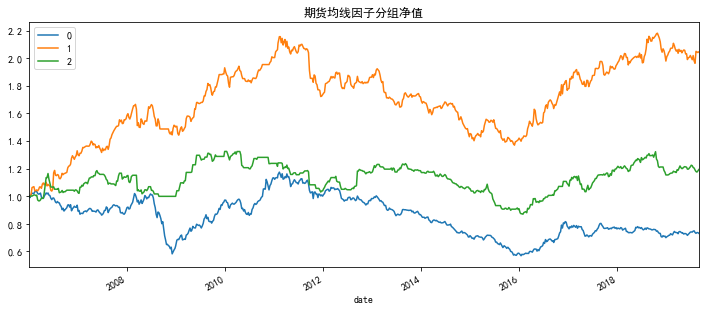

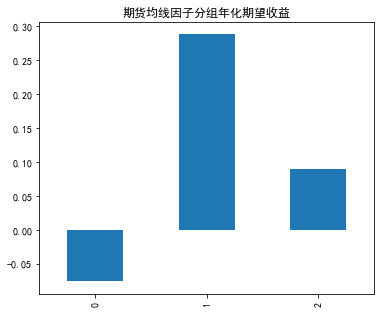

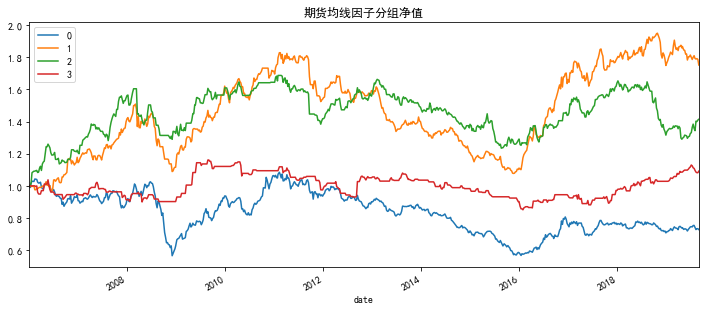

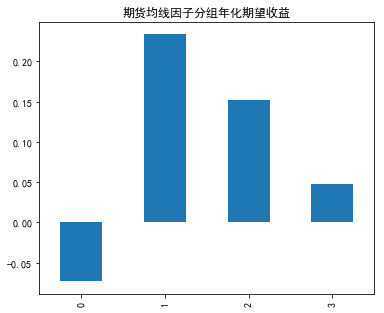

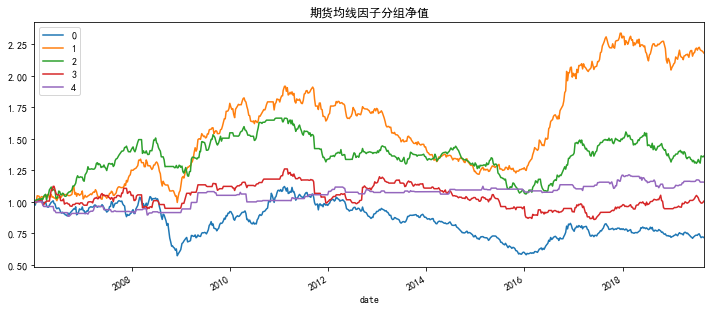

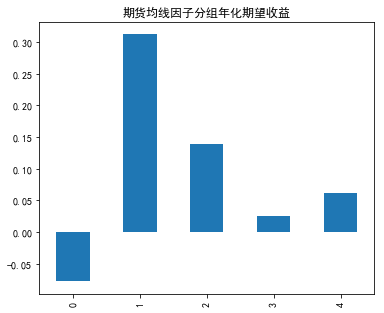

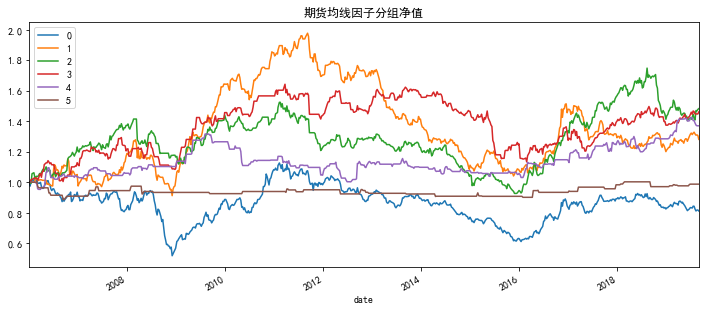

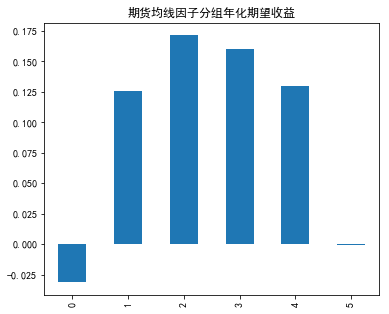

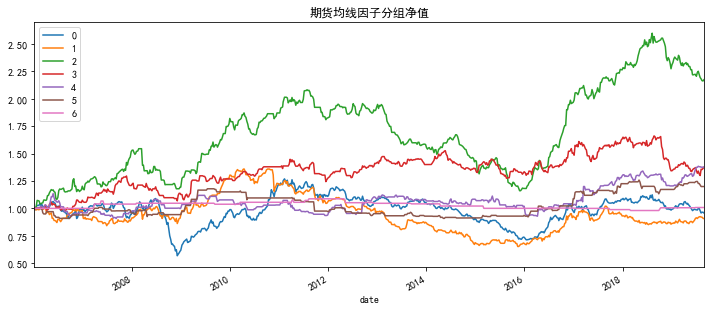

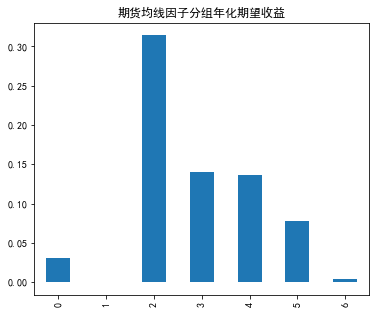

In [589]:
# 根据因子，横截面上分组 - 函数
def Qcut(df,Qn=5):
    df_=df.copy()
    df_['group'] = pd.qcut(df_['next_ret_hat'],Qn,duplicates='drop',labels=False)
    return df_
# 计算分组收益 - 函数
def ComputeRet(df):
    df_=df.copy()
    df_ = df_[df_['group']==group_num].copy()
    return df_['next_ret'].mean()

for Qn in [3,4,5,6,7]:
    # 根据因子，横截面上分组
    mainfutures_Factor_V4=mainfutures_Factor_V3.groupby('date').apply(Qcut,Qn=Qn).reset_index(drop=True)
    # 计算分组收益
    mainfutures_Factor_V5 = pd.DataFrame()
    for group_num in range(Qn):
        mainfutures_Factor_V5=pd.concat([mainfutures_Factor_V5,mainfutures_Factor_V4.groupby('date').apply(ComputeRet).to_frame(group_num)],axis=1)
    mainfutures_Factor_V5=(mainfutures_Factor_V5.shift(1).fillna(0)+1).cumprod()
    # 结果展示
    # mainfutures_Factor_V5['re']=mainfutures_Factor_V5[mainfutures_Factor_V5.columns[-1]]/mainfutures_Factor_V5[0]
    mainfutures_Factor_V5.plot(figsize=(12,5),title='期货均线因子分组净值')
    plt.show()
    (mainfutures_Factor_V5.pct_change().mean()*252).plot.bar(figsize=(6,5),title='期货均线因子分组年化期望收益')
    plt.show()

月度策略的分组效果较差，多空对冲结果也较差，每月调整的均线因子用以预测下一个月收益较难，这一结果是复合逻辑与预期的，均线系统于每月末得到的信号仅适用于短期趋势预测。  
将月度策略转换为周度后，预测窗口变短，模型与信号更迭变快，预测效果变好 - 周度分组后的所有结果普遍优于月度分组后的所有结果。  
但周度策略得到的均线因子分组收益并不单调，一个异象是因子的中间组收益表现较好：因子本身数值是使用均线信号预测的未来收益，中间组是预测值较为接近0的组，其含义是根据历史观测结果，本期的均线信号组合属于不具有明显预测效果（不好也不差）一类，结果却能够取得较好收益。

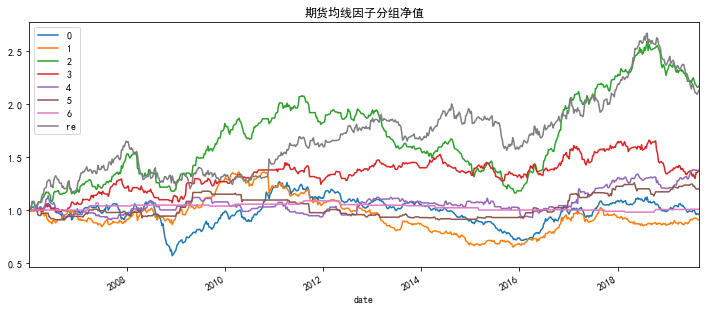

In [590]:
# 结果展示
mean_series = (mainfutures_Factor_V5.pct_change().mean()*252)
winner = mean_series.idxmax()
loser = mean_series.idxmin()
mainfutures_Factor_V5_tmp=mainfutures_Factor_V5.pct_change()
mainfutures_Factor_V5_tmp['re']=mainfutures_Factor_V5_tmp[winner]-mainfutures_Factor_V5_tmp[loser]
mainfutures_Factor_V5['re']=(mainfutures_Factor_V5_tmp.fillna(0)+1).cumprod()['re']
mainfutures_Factor_V5.plot(figsize=(12,5),title='期货均线因子分组净值')
plt.show()

将表现最好的组与表现最差的组进行净值对比后可以得到具有一定强度的曲线，在2016年以后该多空对冲净值曲线呈现快速上升趋势  
**（结果对beta系数平滑窗口较为敏感，不是一个普遍成立的结论）**

## 收益率持续性检验

In [591]:
# 转化为月度数据
mainfutures_TradeData_df_ = mainfutures_TradeData_df.copy()
mainfutures_TradeData_df_.index = pd.to_datetime(mainfutures_TradeData_df_.index)
mainfutures_TradeData_df_['date'] = mainfutures_TradeData_df_.index
def Resample(df):
    df_=df.copy().sort_values('date')
    return df_.apply(lambda x: x.resample('M').last()).reset_index(drop=True)
mainfutures_TradeData_df_M = mainfutures_TradeData_df_.groupby('class').apply(Resample).reset_index(drop=True)

In [592]:
# 期货代码与中文对照字典
mainfutures_name=mainfutures_TradeData_df_M.groupby('class').last().reset_index()
mainfutures_nameD=dict(zip(mainfutures_name['class'],mainfutures_name['class_name'].apply(lambda x: x.replace('主力合约',''))))

In [593]:
# 日度行情数据，添加日期列，数据格式时间
mainfutures_TradeData = mainfutures_TradeData_df.copy()
mainfutures_TradeData.index = pd.to_datetime(mainfutures_TradeData.index)
mainfutures_TradeData['date'] = mainfutures_TradeData.index
mainfutures_TradeData=mainfutures_TradeData.reset_index(drop=True)
mainfutures_TradeData = mainfutures_TradeData.set_index(['class_name','class','date']).dropna(how='all').reset_index()

In [594]:
# 获取月度交易日
mainfutures_TradeM = pd.to_datetime(sorted(mainfutures_TradeData_df_M['date'].unique()))

In [595]:
# 日度数据计算月度因子
# 计算月度已实现波动 - 等权标准差 OR 指数加权
def ComputeRVol(df,hisW=63):
    df_=df.copy().sort_values('date')
    save_dict = {}
    save_dict['class'] = [df_['class'].tolist()[0]]
    df_['ret'] = df_['close']/df_['close'].shift(1)-1
#     sigma = df_['ret'][-hisW:].std()*(252**0.5)
    sigma = df_['ret'][-hisW:].ewm(span=63,adjust=False,min_periods=63).std().tolist()[-1]*(252**0.5)
    return pd.DataFrame([sigma],columns=['sigmaY'])

mainfutures_M_Allsigma = pd.DataFrame()
for MdateCnt in range(4,len(mainfutures_TradeM)):
    Mdate = mainfutures_TradeM[MdateCnt]
    Last_Mdate = mainfutures_TradeM[MdateCnt-4]
    mainfutures_M = mainfutures_TradeData[(mainfutures_TradeData['date']>=Last_Mdate) & (mainfutures_TradeData['date']<=Mdate)].copy()
    mainfutures_M_sigma = mainfutures_M.groupby('class').apply(ComputeRVol,hisW=63)
    mainfutures_M_sigma.index=mainfutures_M_sigma.index.droplevel(1)
    mainfutures_M_sigma=mainfutures_M_sigma.reset_index(drop=False)
    mainfutures_M_sigma['date'] = Mdate
    mainfutures_M_Allsigma = pd.concat([mainfutures_M_Allsigma,mainfutures_M_sigma],axis=0,sort=True)

In [596]:
# 计算期货月收益
def ComputeRet(df):
    df_=df.copy().sort_values('date')
    df_['ret_mY']=(df_['close']/df_['close'].shift(1)-1)*12
    return df_
mainfutures_ret = mainfutures_TradeData_df_M.groupby('class').apply(ComputeRet).reset_index(drop=True)

In [597]:
# 计算风险调整收益
mainfutures_ForContinue = mainfutures_ret.merge(mainfutures_M_Allsigma,on=['date','class'],how='left').dropna()
mainfutures_ForContinue['ret_sigma'] = mainfutures_ForContinue['ret_mY']/mainfutures_ForContinue['sigmaY']

In [598]:
# 对风险调整收益进行盖帽处理，避免outliner过度影响回归结果
def extreme_process_MAD(data,num=3):#data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准
    data_=data.copy()  # 为不破坏原始数据，先对其进行拷贝
    NotNumList = ['class','date']
    feature_names = [i for i in data_.columns.tolist() if i not in NotNumList]   #获取数据集中需测试的因子名
    median=data_[feature_names].median(axis=0)  #获取中位数
    MAD=abs(data_[feature_names].sub(median,axis=1)).median(axis=0) #按列索引匹配，并在行中广播
    data_.loc[:,feature_names]=data_.loc[:,feature_names].clip(lower=median-num*1.4826*MAD,upper=median+num*1.4826*MAD,axis=1) #利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    return data_
mainfutures_ForContinue_exOut = extreme_process_MAD(mainfutures_ForContinue[['class','date','ret_sigma']].copy())
# mainfutures_ForContinue_exOut = mainfutures_ForContinue[['class','date','ret_sigma']].copy()

In [541]:
# 数据较充足的期货
futureList=['A9999.XDCE', 'AG9999.XSGE', 'AL9999.XSGE', 'AU9999.XSGE',
       'B9999.XDCE', 'BB9999.XDCE', 'BU9999.XSGE', 'C9999.XDCE',
       'CF9999.XZCE', 'CU9999.XSGE', 'FB9999.XDCE', 'FG9999.XZCE',
       'FU9999.XSGE', 'HC9999.XSGE', 'I9999.XDCE', 'IF9999.CCFX',
       'J9999.XDCE', 'JD9999.XDCE', 'JM9999.XDCE', 'JR9999.XZCE',
       'L9999.XDCE', 'M9999.XDCE', 'MA9999.XZCE', 'OI9999.XZCE',
       'P9999.XDCE', 'PB9999.XSGE', 'PM9999.XZCE', 'PP9999.XDCE',
       'RB9999.XSGE', 'RI9999.XZCE', 'RM9999.XZCE', 'RO9999.XZCE',
       'RS9999.XZCE', 'RU9999.XSGE', 'SR9999.XZCE', 'TA9999.XZCE',
       'V9999.XDCE', 'WH9999.XZCE', 'WR9999.XSGE', 'WS9999.XZCE',
       'WT9999.XZCE', 'Y9999.XDCE', 'ZN9999.XSGE']

In [542]:
def lagfun(df,lag):
    df_=df.copy().sort_values('date')
    df_['ret_sigma_lag%d'%(lag)]=df_['ret_sigma'].shift(lag)
    return df_
lag_list = []
tvalues_list = []
for lag in range(1,61):
    tvalues_list_sub=[]
    kind_list=[]
    mainfutures_ForContinue_exOutV0 = mainfutures_ForContinue_exOut.groupby('class').apply(lagfun,lag=lag).reset_index(drop=True).dropna()
    # 全期货混合回归
    X=mainfutures_ForContinue_exOutV0[['ret_sigma_lag%d'%(lag)]]
    y=mainfutures_ForContinue_exOutV0[['ret_sigma']]
    X_c=sm.add_constant(X)
    lag_list.append(lag)
    tvalues_list_sub.append(sm.OLS(y,X_c).fit().tvalues['ret_sigma_lag%d'%(lag)])
    kind_list.append('ALL')
    # 单个期货回归
    for kind in futureList:
        mainfutures_ForContinue_exOutV0_sub=mainfutures_ForContinue_exOutV0[mainfutures_ForContinue_exOutV0['class']==kind].copy()
        X=mainfutures_ForContinue_exOutV0_sub[['ret_sigma_lag%d'%(lag)]]
        y=mainfutures_ForContinue_exOutV0_sub[['ret_sigma']]
        X_c=sm.add_constant(X)
        tvalues_list_sub.append(sm.OLS(y,X_c).fit().tvalues['ret_sigma_lag%d'%(lag)])
        kind_list.append(kind)
    tvalues_list.append(tvalues_list_sub)
retContinueDf = pd.DataFrame(dict(zip(lag_list,tvalues_list)))
retContinueDf.index=kind_list

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp in

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp in

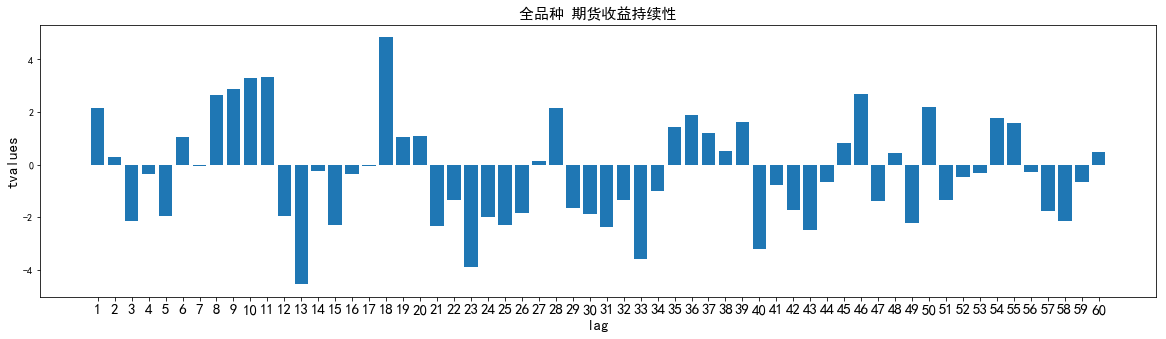

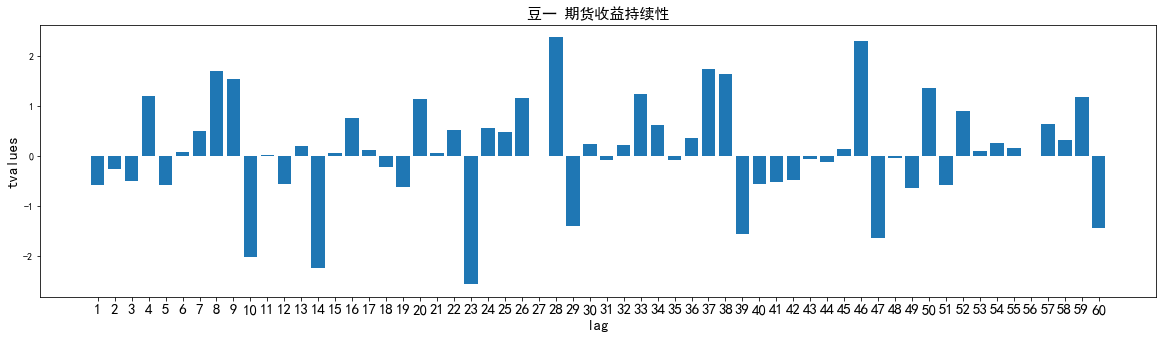

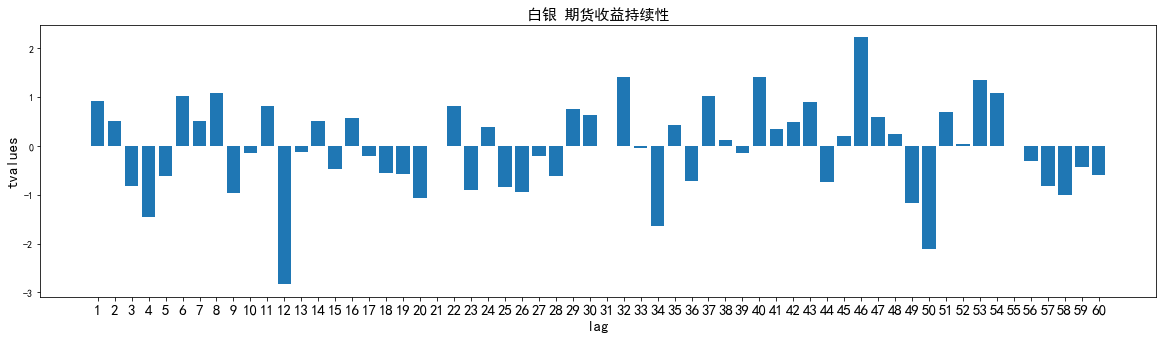

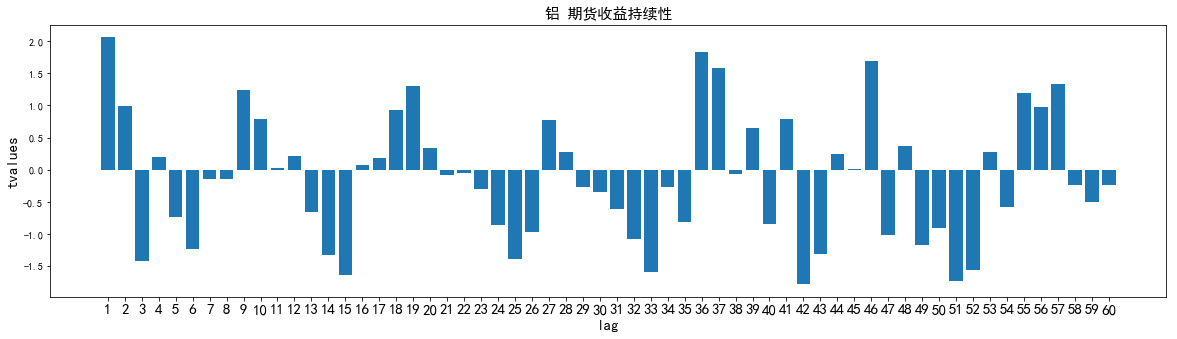

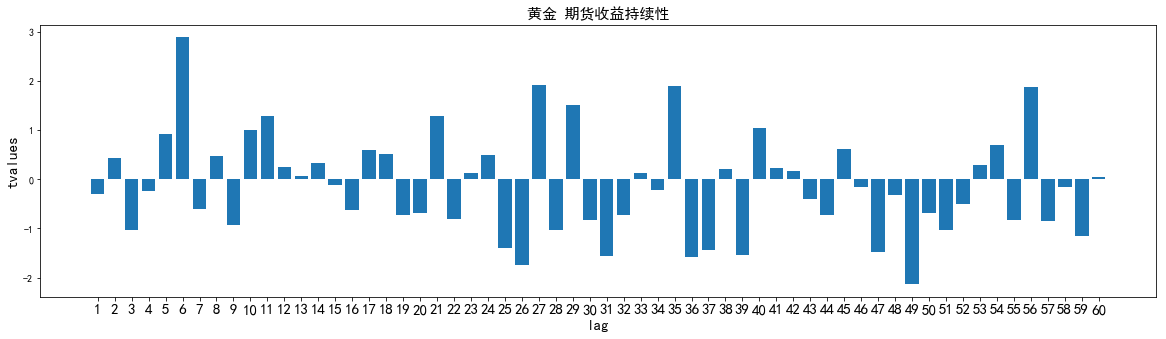

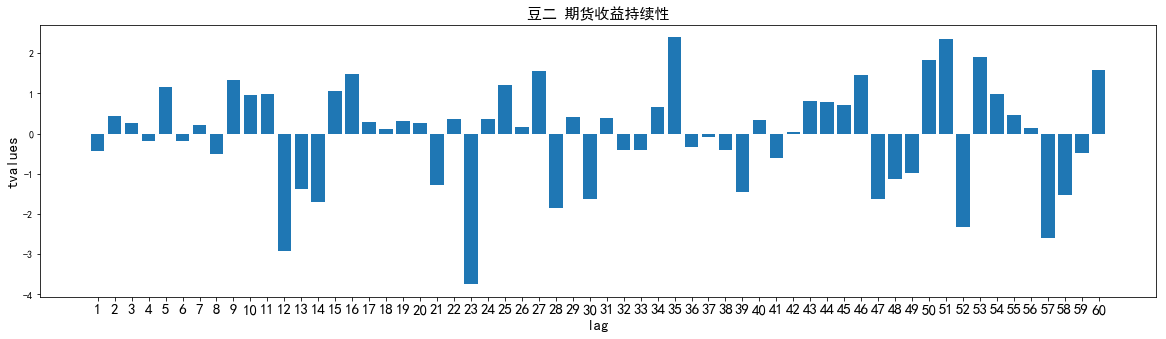

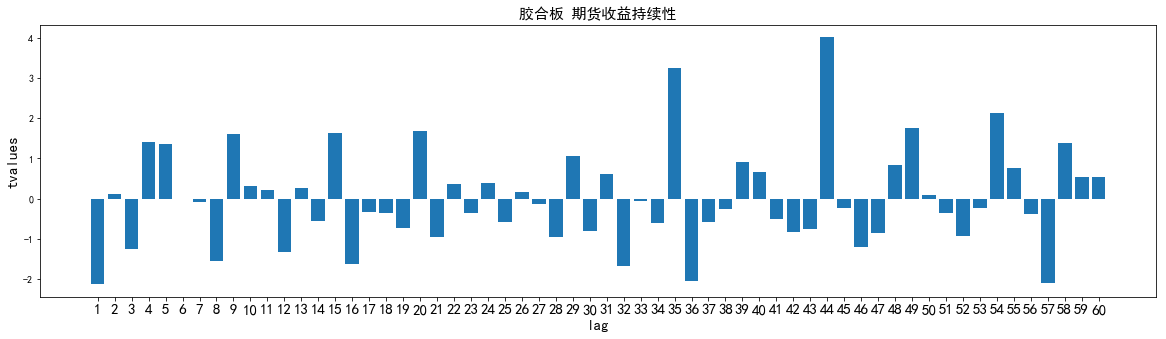

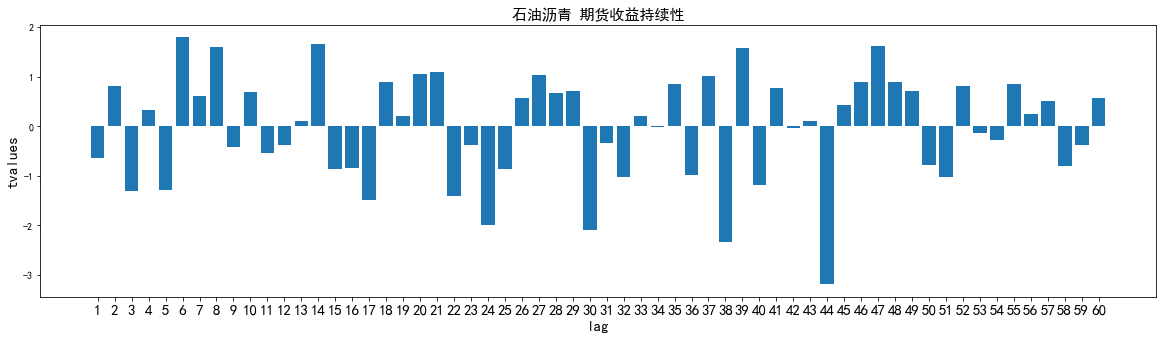

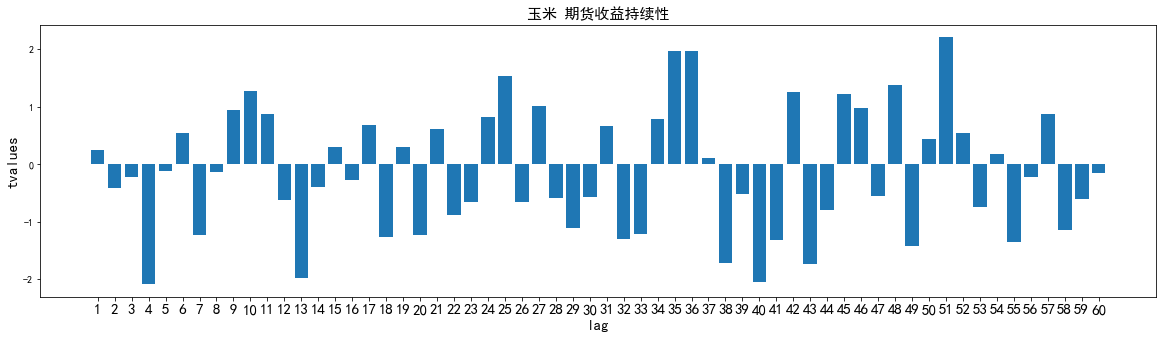

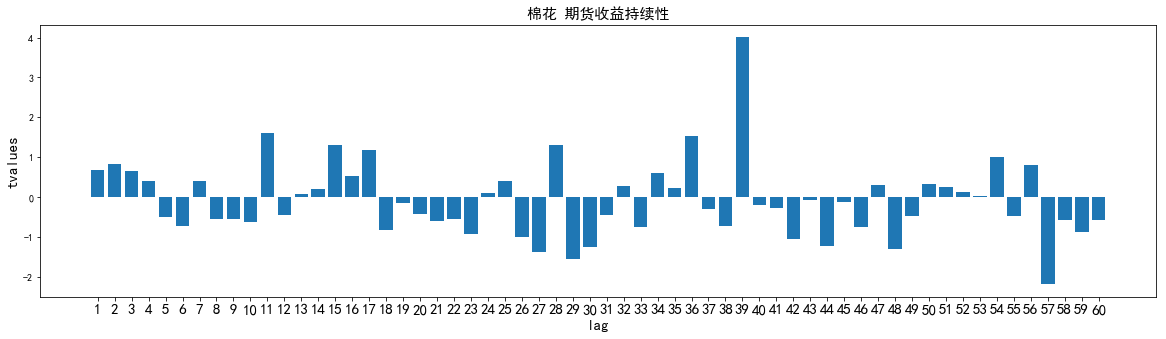

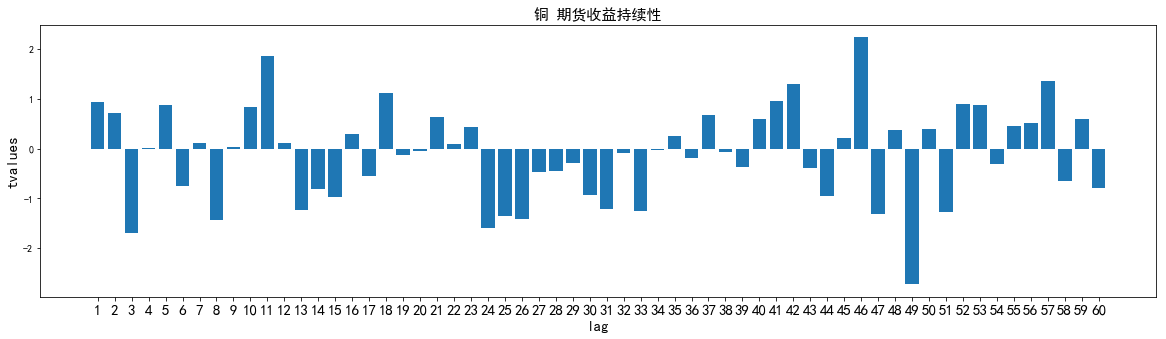

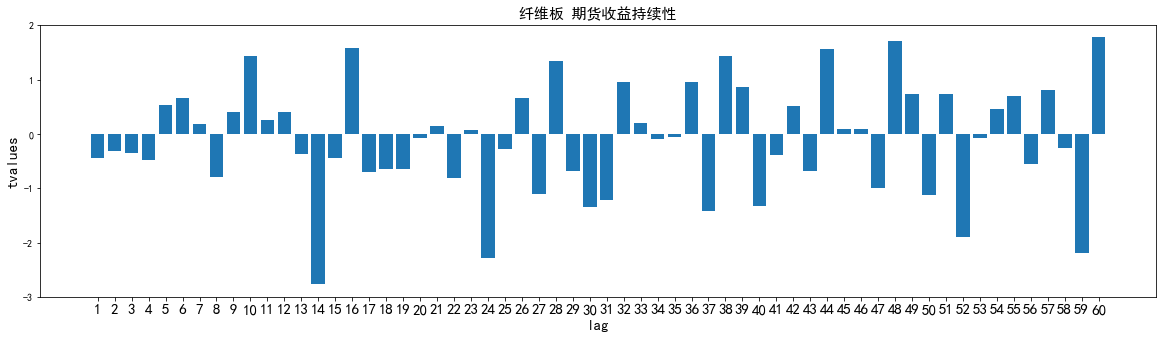

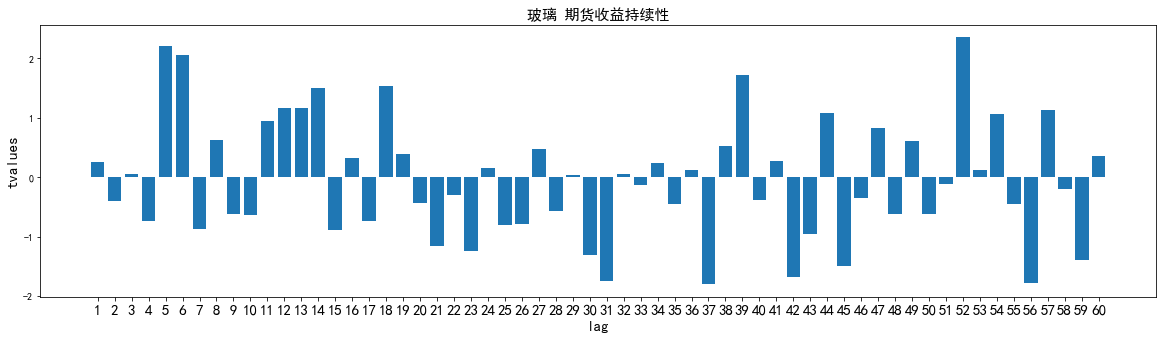

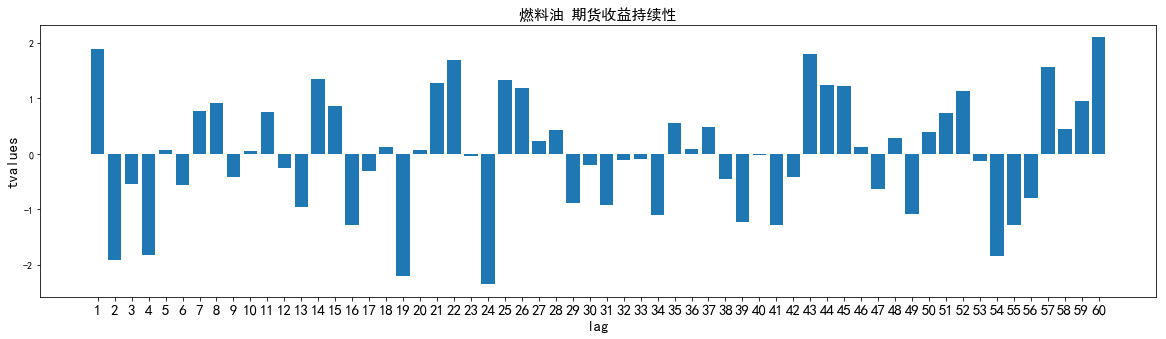

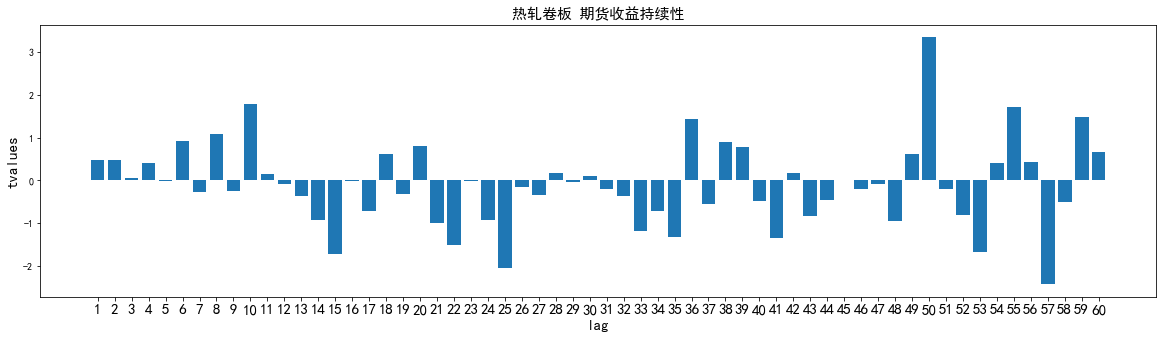

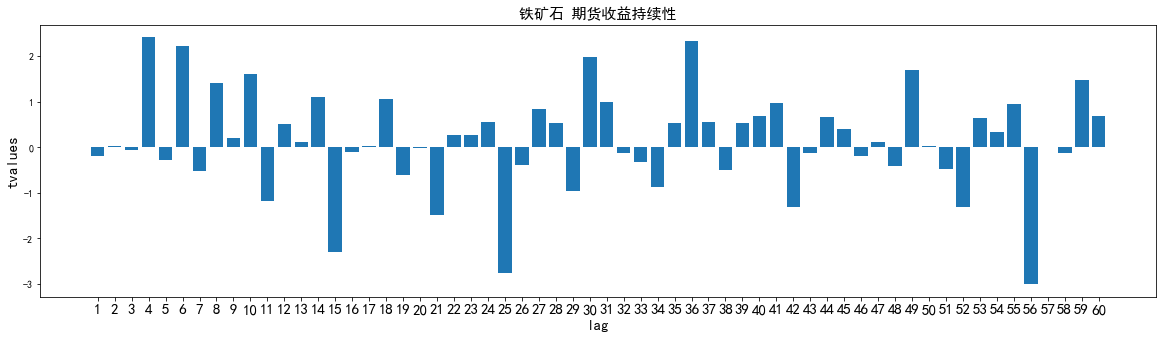

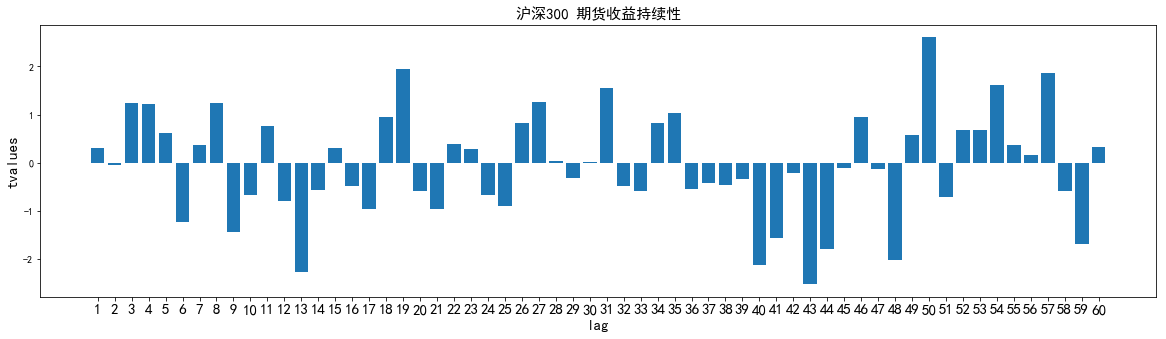

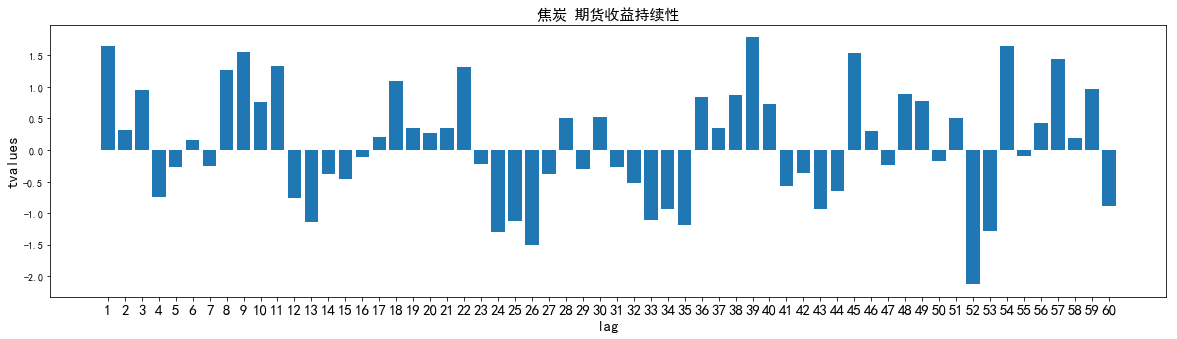

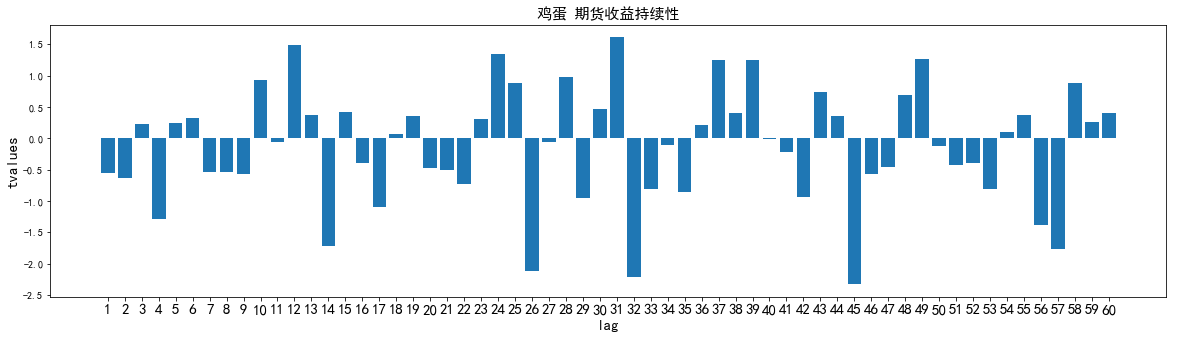

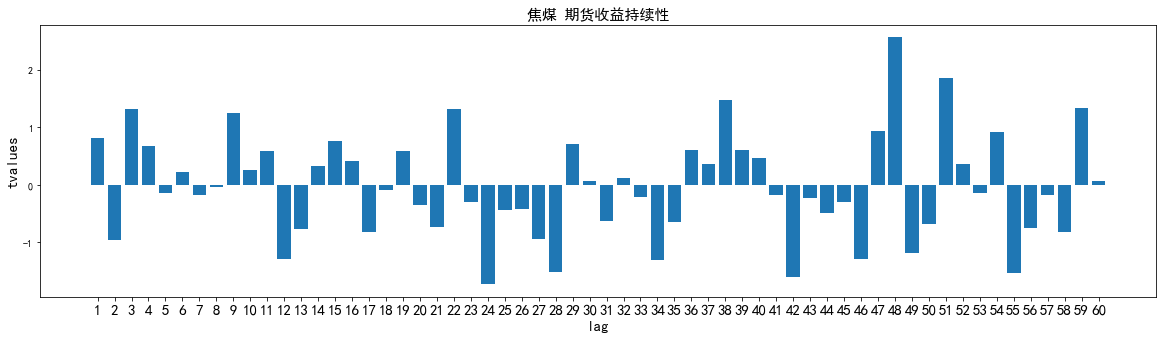

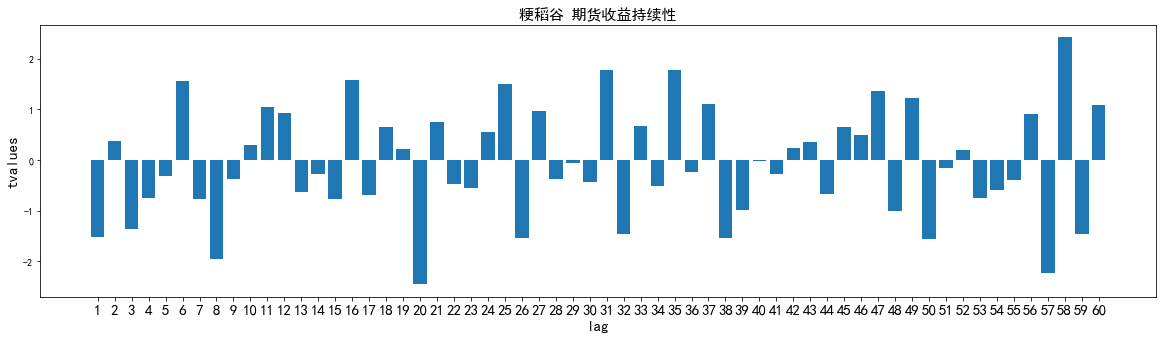

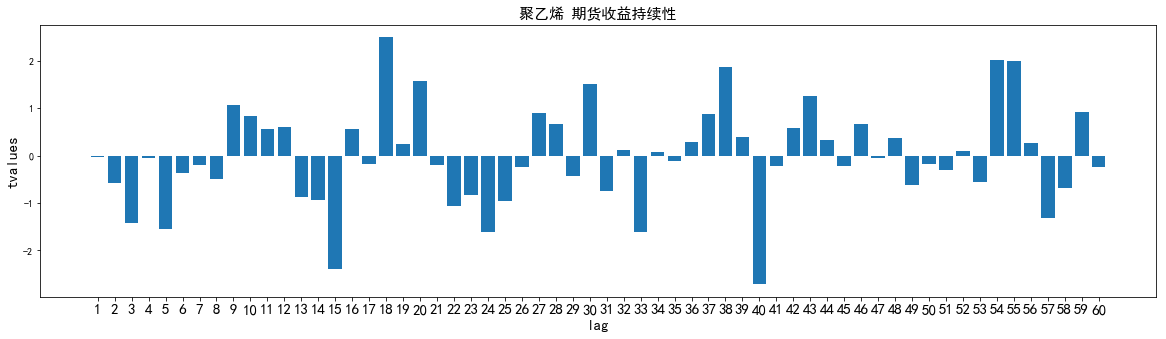

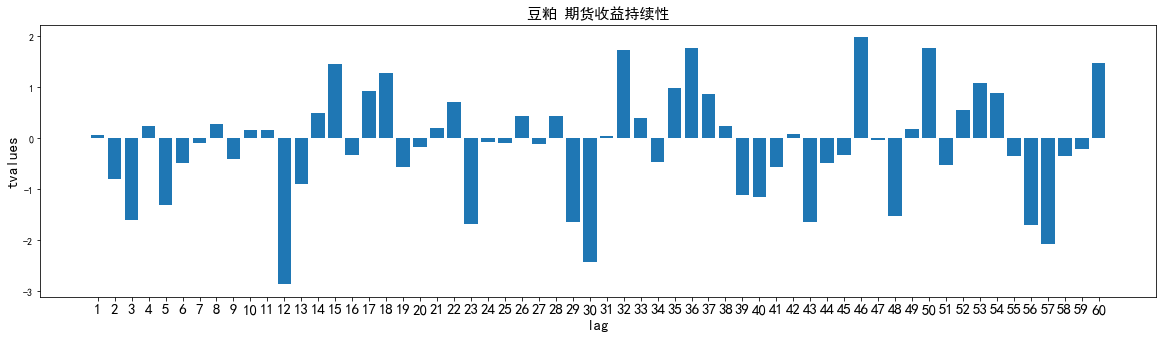

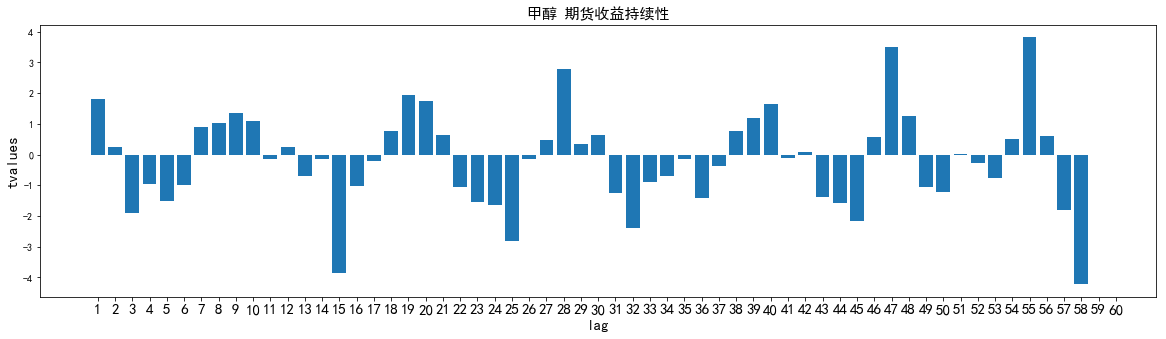

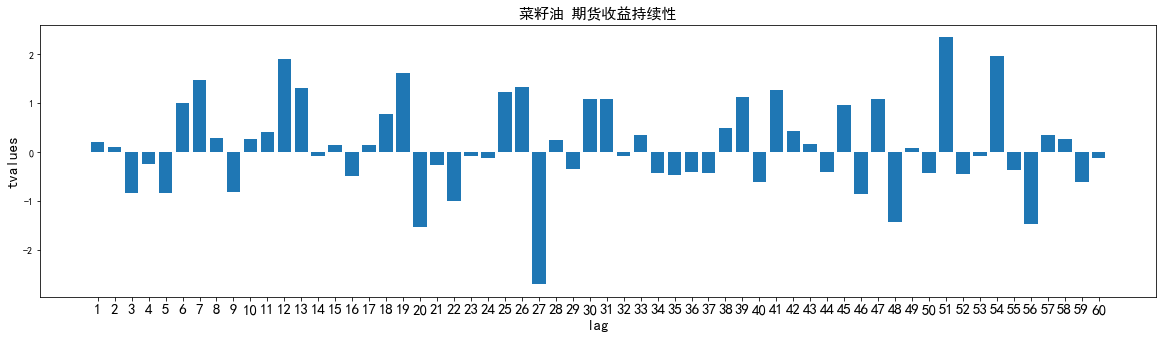

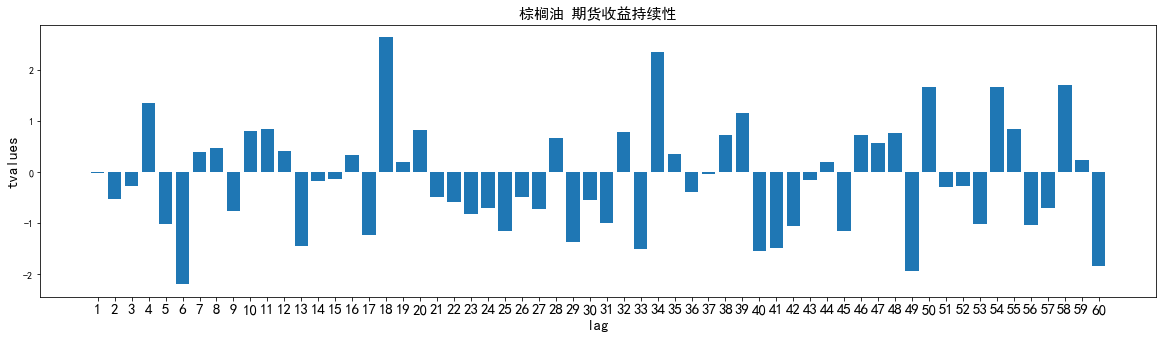

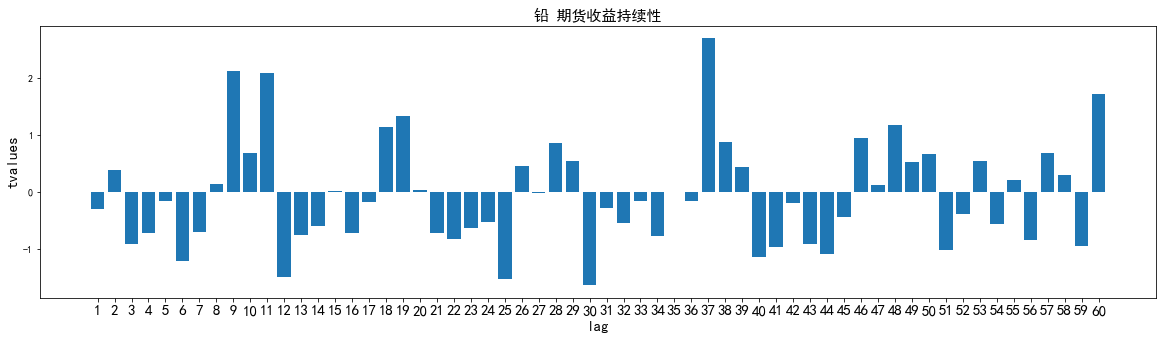

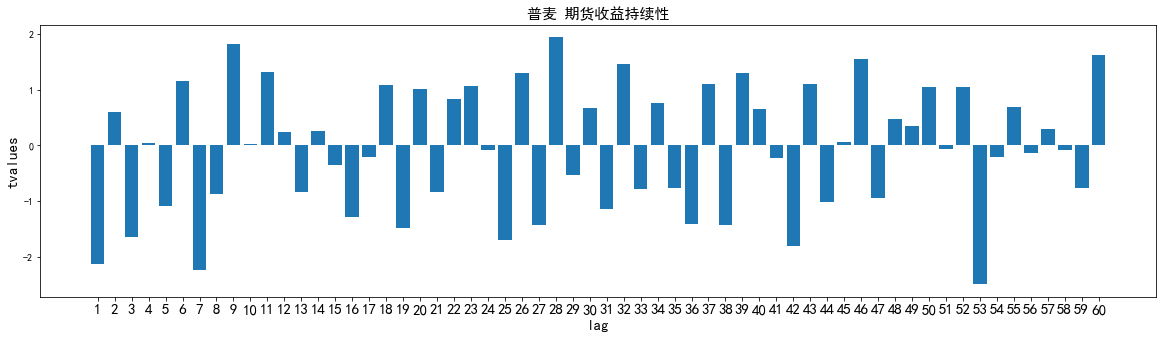

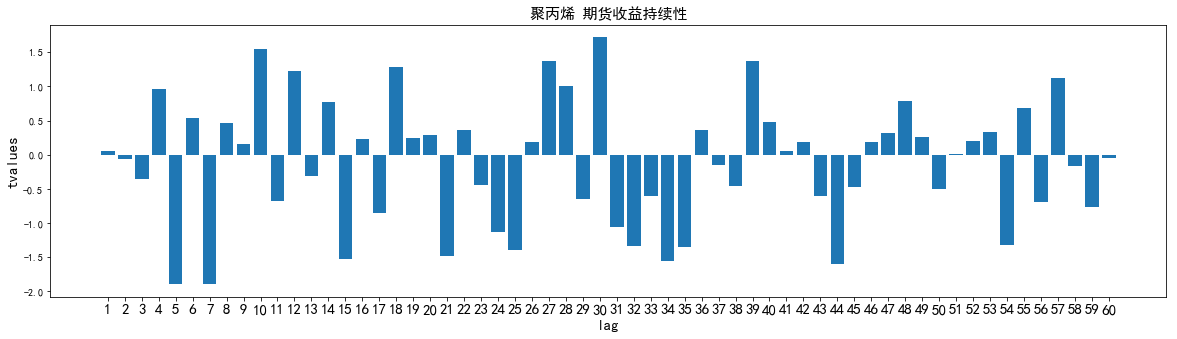

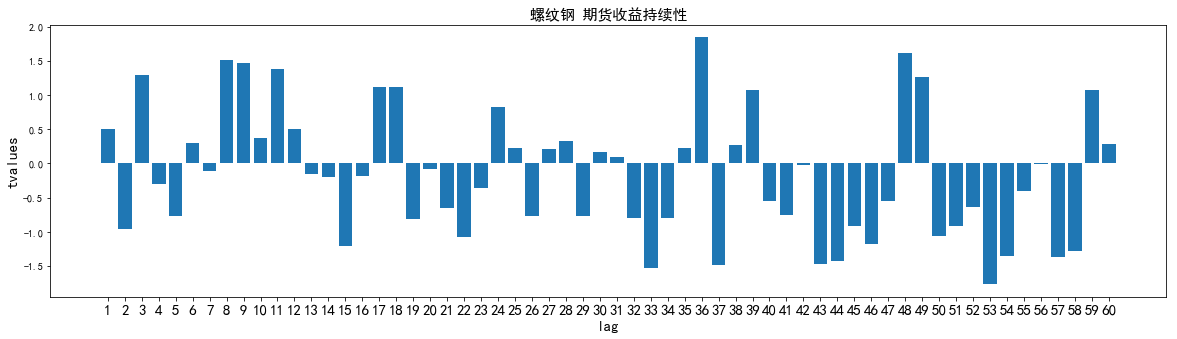

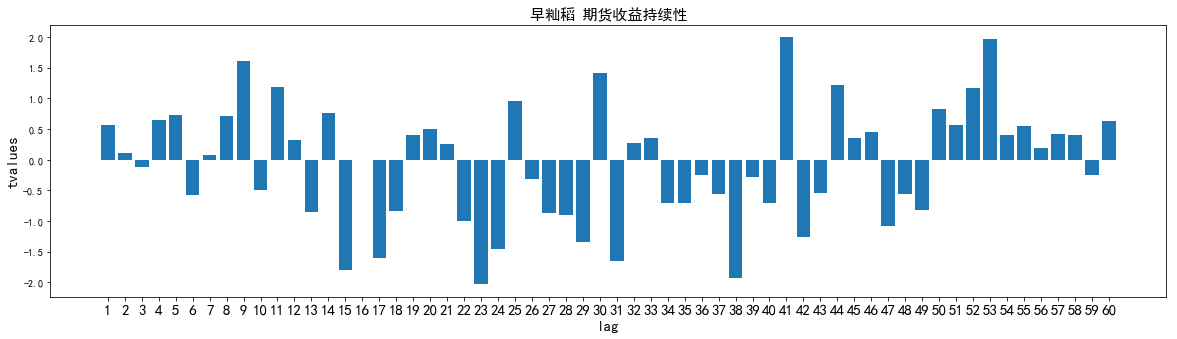

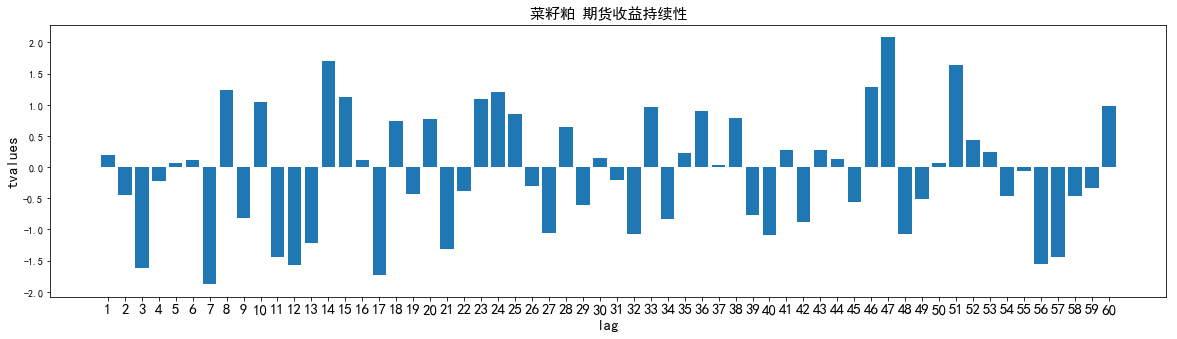

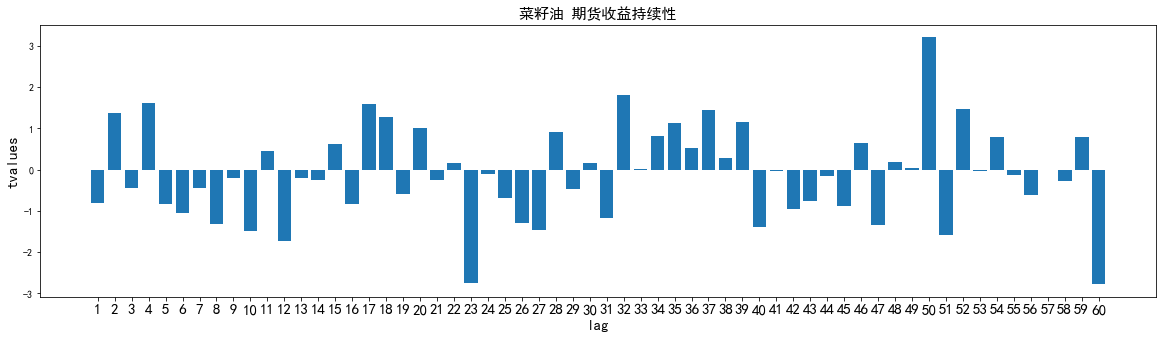

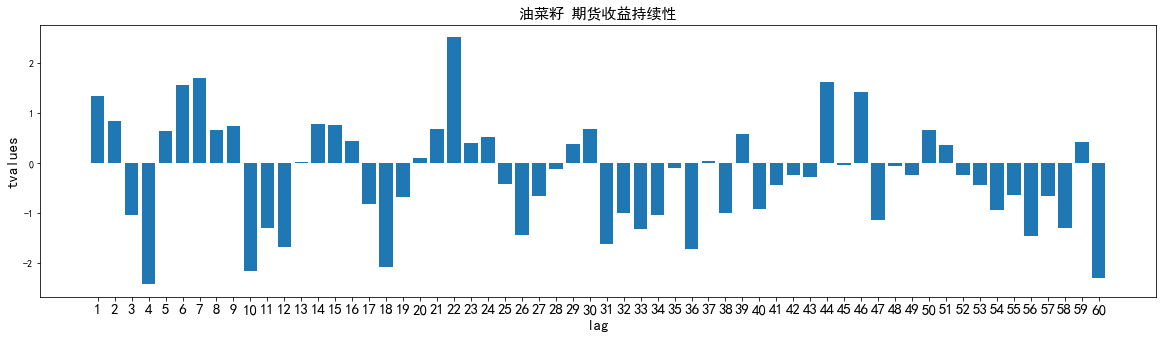

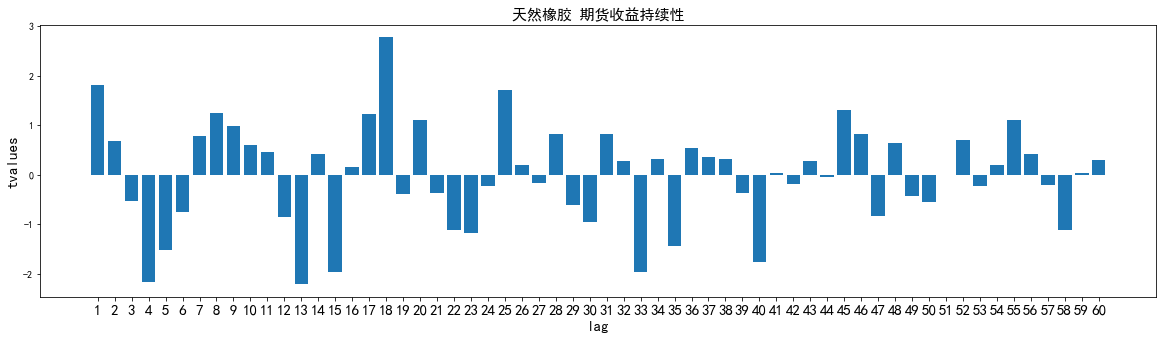

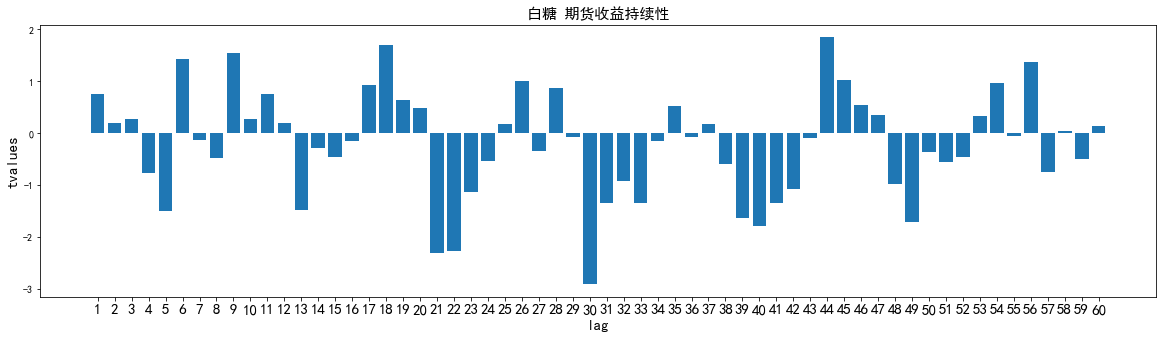

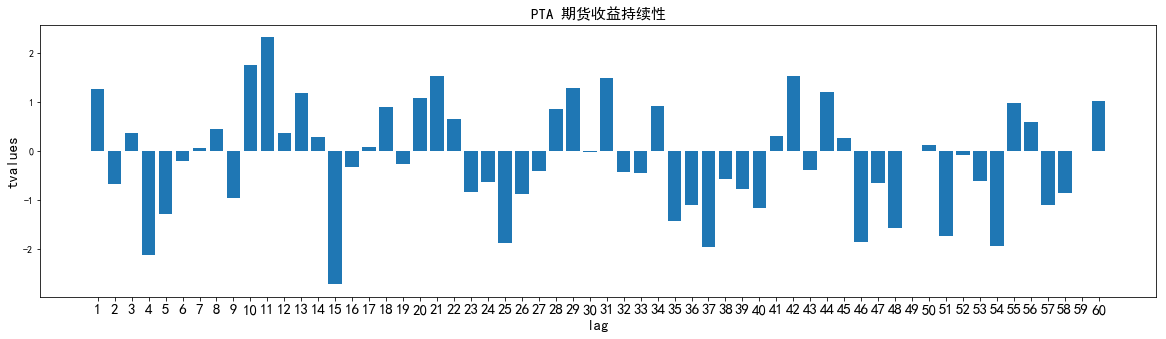

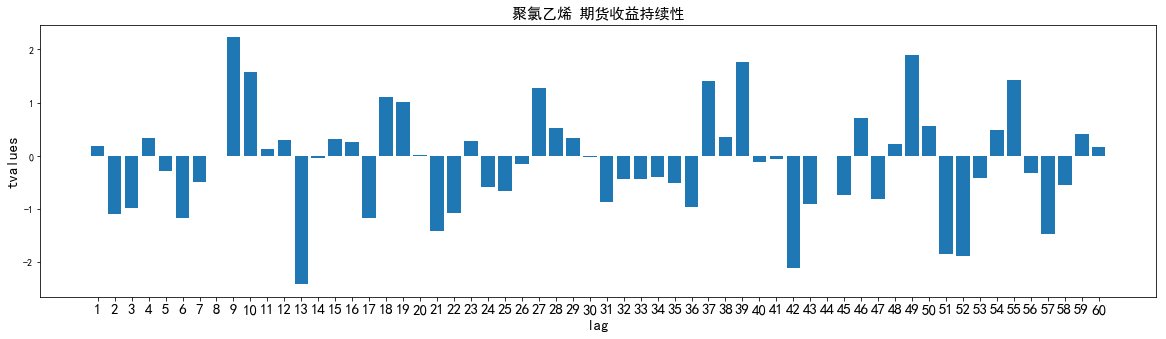

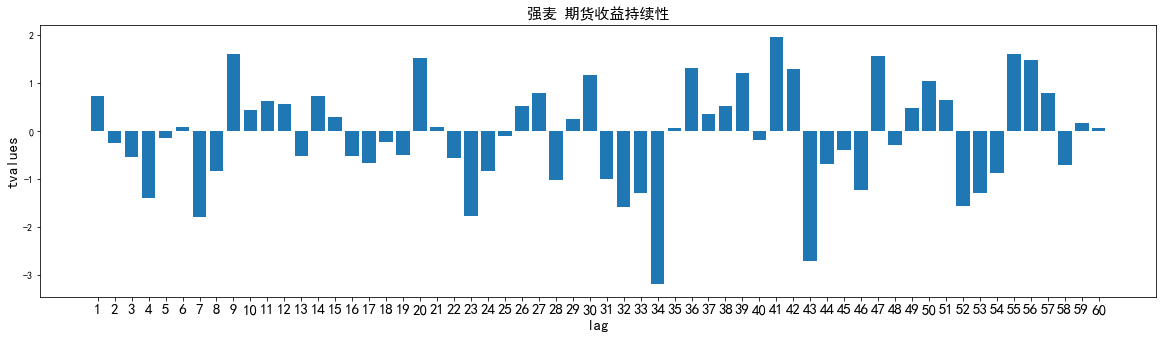

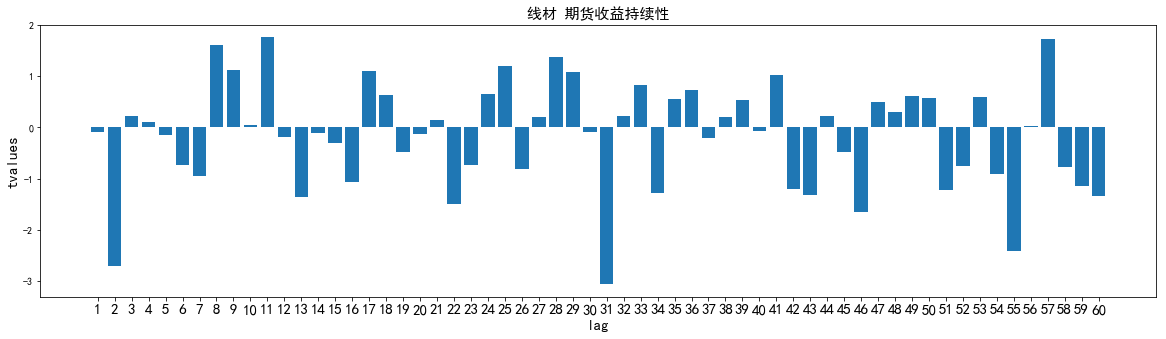

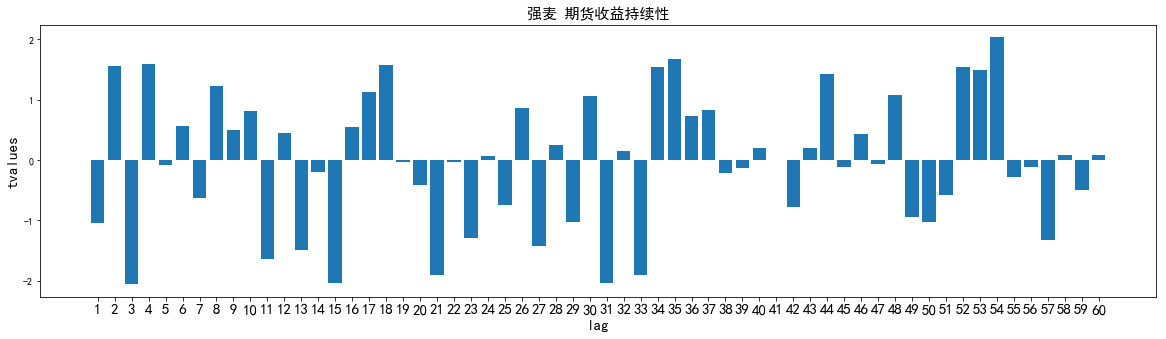

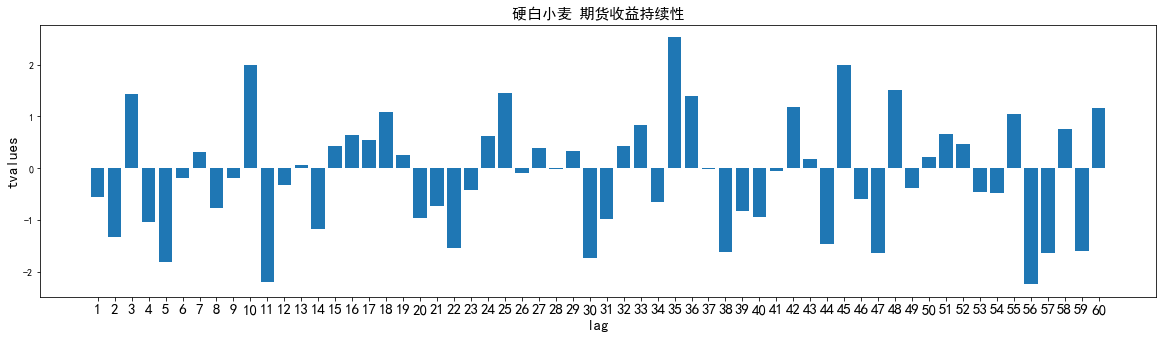

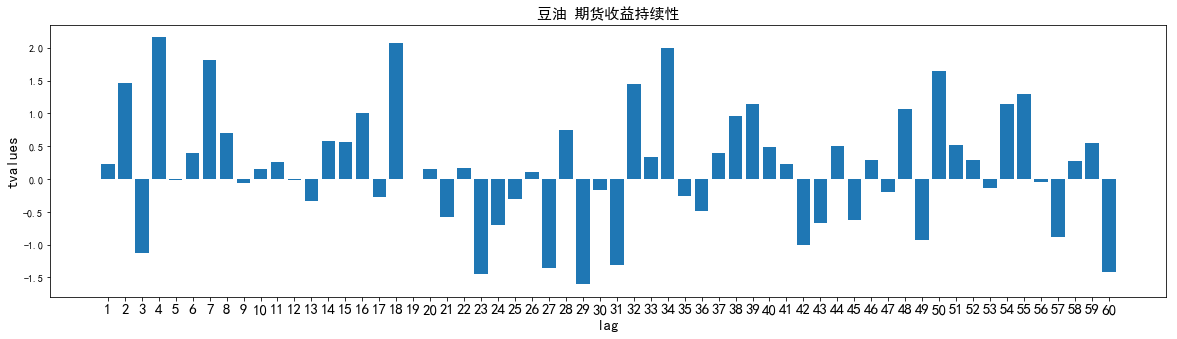

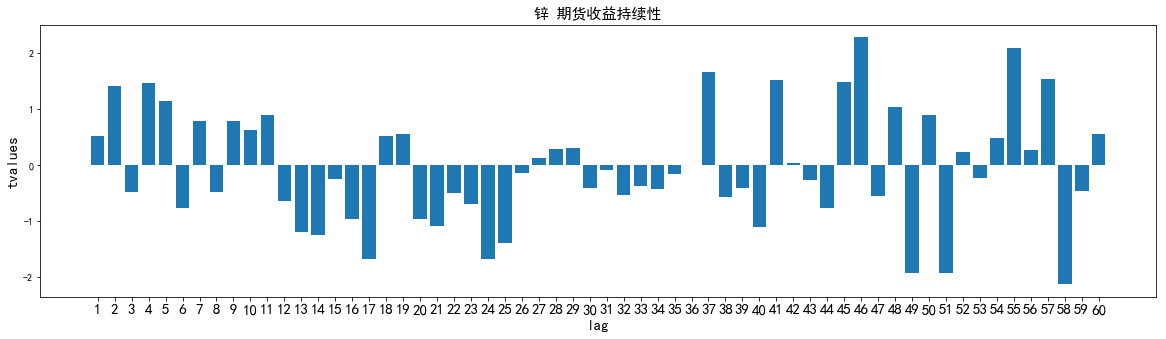

In [565]:
# 收益持续性 - 自回归滞后阶数与t统计量条形图
retContinueDfAll = retContinueDf.T
mainfutures_nameD['ALL'] = '全品种'
for col in retContinueDfAll.columns:
    retContinueDf_sub = retContinueDfAll[[col]].copy()
    plt.figure(figsize=(20,5))
    plt.bar(retContinueDf_sub.index,retContinueDf_sub[col])
    plt.xlabel('lag',fontsize=15)
    plt.ylabel('tvalues',fontsize=15)
    plt.title('%s 期货收益持续性'%(mainfutures_nameD[col]),fontsize=15)
    plt.xticks(retContinueDf.T.index,rotation=0,fontsize=15)
    plt.show()

整体呈现一定的收益持续性，各品种之间的收益持续性区别较大，可分版块研究收益持续性特点，考虑将主力合约替换为指数，加入债券数据！